# Generate Theoretical Isotherms

Given a set of physical parameters and a pattern of epigenetic marks, generate a theoretical isotherm. Note that the theoretical isotherm assumes that all nucleosomes are separated by some distance such that binders on adjacent nucleosomes can interact.

#### Specify Package Root Directory

In [1]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Navigate one level up to get the root directory path
root_directory = os.path.abspath(os.path.join(notebook_directory, '..'))

# Change the working directory to the root directory
os.chdir(root_directory)

# Append the root directory to sys.path
sys.path.append(root_directory)

#### Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sliding_nucleosome.nucleo_arr as nuc
import sliding_nucleosome.linkers as link
from sliding_nucleosome import mc
from binding_model import mc_bind

#### Initialize Physical Parameters

In [3]:
# Specify physical parameters
J = np.atleast_2d([-3.92])
B = np.atleast_2d([-1.5])

# Generate a methylation sequence
n_beads = 500
frac_methyl = 0.1
methyl_corr_length = 18.4
marks = nuc.gen_meth(n_beads, frac_methyl, methyl_corr_length)
marks = np.atleast_2d(marks).T

# Specify the polymer
gamma = np.ones(marks.shape[0])
nbi = np.array([2])
linker_corr_length = 45
linker_lengths = np.ones(marks.shape[0])
a = int(np.floor(15.1))
lam = -np.log(1 - 1 / linker_corr_length)

In [4]:
# Let's match the methylation pattern that shows two-phase co-existance
marks = np.array([
    1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 2., 1., 1., 1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 2., 1., 1., 1., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
    1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    0., 0., 0., 0., 0., 0., 0.
])
marks = np.atleast_2d(marks).T

In [5]:
# Print the methylation pattern
print("Methylation Pattern (flattened, single mark):\n")
print(marks.flatten())

Methylation Pattern (flattened, single mark):

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1. 1.
 1. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 2. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 

#### Generate Theoretical Isotherms

We calculate theoretical average binding fractions for various chemical potentials, then we plot the average binding fractions against the chemical potentials to generate a theoretical isotherm.

In [6]:
def differentiate_transfer_matrix(T):
    """Differentiate a transfer matrix with respect to mu_t.
    """
    dT = T.copy()
    dT[0, 0] = 0
    dT[0, 1] *= 0.5
    dT[1, 0] *= 0.5
    dT[1, 2] *= 1.5
    dT[2, 1] *= 1.5
    dT[2, 2] *= 2
    return dT


def compute_theoretical_binding_fraction(nuc_arr):
    
    # How many binder states exist?
    Nr = nuc_arr.Nbi[0] + 1
    
    # Compute derivatives
    dT_all = [
        differentiate_transfer_matrix(nuc_arr.T_all[:, :, i])
        for i in range(nuc_arr.n_beads)
    ]
    
    # Compute partition function and normalization factors
    Z, alphas = link.compute_partition_function(nuc_arr.T_all)
    
    # Pre-compute left and right partial matrix product
    N = nuc_arr.n_beads
    T_left = {}
    T_right = {}
    for i in range(N):
        if i == 0:
            T_left[i] = np.identity(Nr)
        else:
            T_left[i] = np.matmul(T_left[i-1], nuc_arr.T_all[:, :, i-1]) / alphas[i-1]
    for ind in range(N):
        i = N - ind - 1
        if i == N-1:
            T_right[i] = np.identity(Nr)
        else:
            T_right[i] = np.matmul(nuc_arr.T_all[:, :, i+1], T_right[i+1]) / alphas[i]
    
    # Compute derivative
    dZ = np.zeros((Nr, Nr))
    for i in range(N):
        dZ += np.matmul(np.matmul(T_left[i], dT_all[i]), T_right[i])

    # Calculate theoretical binding fraction
    theta_theory = 1 / (nuc_arr.Nbi[0] * N * Z) * np.trace(dZ)

    return theta_theory

In [7]:
thetas = []
all_mu = np.linspace(-10.5, -9.5, 101)

In [8]:
for i, mu in enumerate(all_mu):
    print(f"mu index {i+1} of {len(all_mu)}")

    # Initialize the nucleosome array
    nuc_arr = nuc.NucleosomeArray(
        J = J, B = B, mu = [mu], linker_lengths = linker_lengths,
        a = a, lam = lam, marks = marks, Nbi = nbi
    )
    
    # NEXT STEP: Sample linker length distribution for the chemical potential
    # This will allow us to model binding patterns for the proper values of gamma
    # For now, just assume that the linker lengths are fixed and validate the binding model

    # Calculate the average binding fraction
    theta_theory = compute_theoretical_binding_fraction(nuc_arr)
    
    # Store the average binding fraction
    thetas.append(theta_theory)

mu index 1 of 101
mu index 2 of 101
mu index 3 of 101
mu index 4 of 101
mu index 5 of 101
mu index 6 of 101
mu index 7 of 101
mu index 8 of 101
mu index 9 of 101
mu index 10 of 101
mu index 11 of 101
mu index 12 of 101
mu index 13 of 101
mu index 14 of 101
mu index 15 of 101
mu index 16 of 101
mu index 17 of 101
mu index 18 of 101
mu index 19 of 101
mu index 20 of 101
mu index 21 of 101
mu index 22 of 101
mu index 23 of 101
mu index 24 of 101
mu index 25 of 101
mu index 26 of 101
mu index 27 of 101
mu index 28 of 101
mu index 29 of 101
mu index 30 of 101
mu index 31 of 101
mu index 32 of 101
mu index 33 of 101
mu index 34 of 101
mu index 35 of 101
mu index 36 of 101
mu index 37 of 101
mu index 38 of 101
mu index 39 of 101
mu index 40 of 101
mu index 41 of 101
mu index 42 of 101
mu index 43 of 101
mu index 44 of 101
mu index 45 of 101
mu index 46 of 101
mu index 47 of 101
mu index 48 of 101
mu index 49 of 101
mu index 50 of 101
mu index 51 of 101
mu index 52 of 101
mu index 53 of 101
mu

#### Plot Theoretical Isotherm

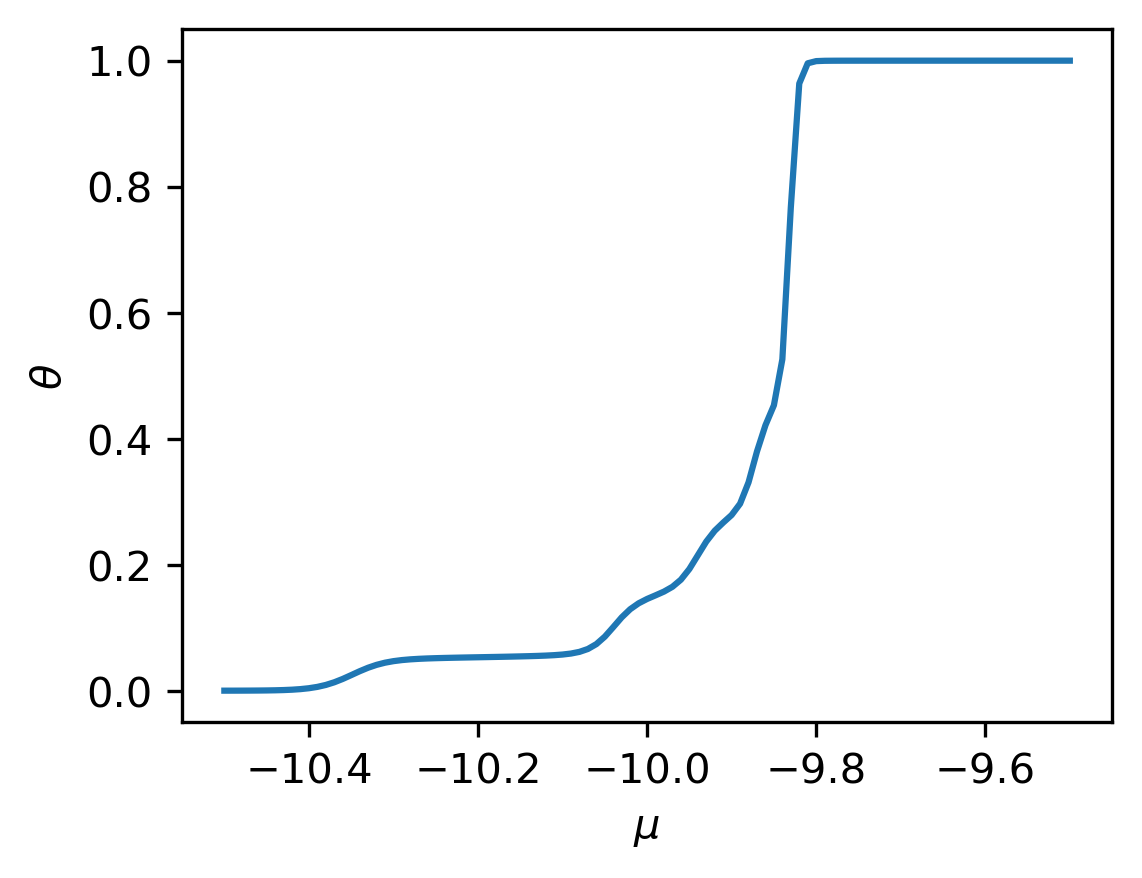

In [9]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(all_mu, thetas)
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\theta$")
plt.show()

#### Validate Theoretical Isotherm with Binding Simulation

We implement a binding simulation to validate the theoretical binding isotherm evaluated above.

In [10]:
# Specify simulation parameters
n_snaps = 100
n_steps_per_snap = 1000

In [11]:
# Specify chemical potentials to include in binding simulation
all_mu_sim = np.linspace(-10.5, -9.5, 11)

# Initialize dictionary of simulated binding states
all_sigma_sim = {}

# Simulate binding profiles for each chemical potential
for mu_sim in all_mu_sim:
    
    print(f"Mu: {mu_sim}")
    
    # Initialize the nucleosome array
    nuc_arr = nuc.NucleosomeArray(
        J = J, B = B, mu = [mu_sim], linker_lengths = linker_lengths,
        a = a, lam = lam, marks = marks, Nbi = nbi
    )
    
    # Initialize a binding pattern
    sigma = np.atleast_2d(np.random.randint(0, 3, size=nuc_arr.n_beads)).T
    
    # Simulate binding
    sigma = mc_bind.mc_N_state_1D(
        nuc_arr,
        sigma,
        n_snaps,
        n_steps_per_snap
    )
    
    # Store the simulated binding states
    all_sigma_sim[mu_sim] = sigma.copy()
    
    print()

Mu: -10.5
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -10.4
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -10.3
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -10.2
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -10.1
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -10.0
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -9.9
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -9.8
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -9.7
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -9.6
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.

Mu: -9.5
Snapshot 50 of 100 complete.
Snapshot 100 of 100 complete.



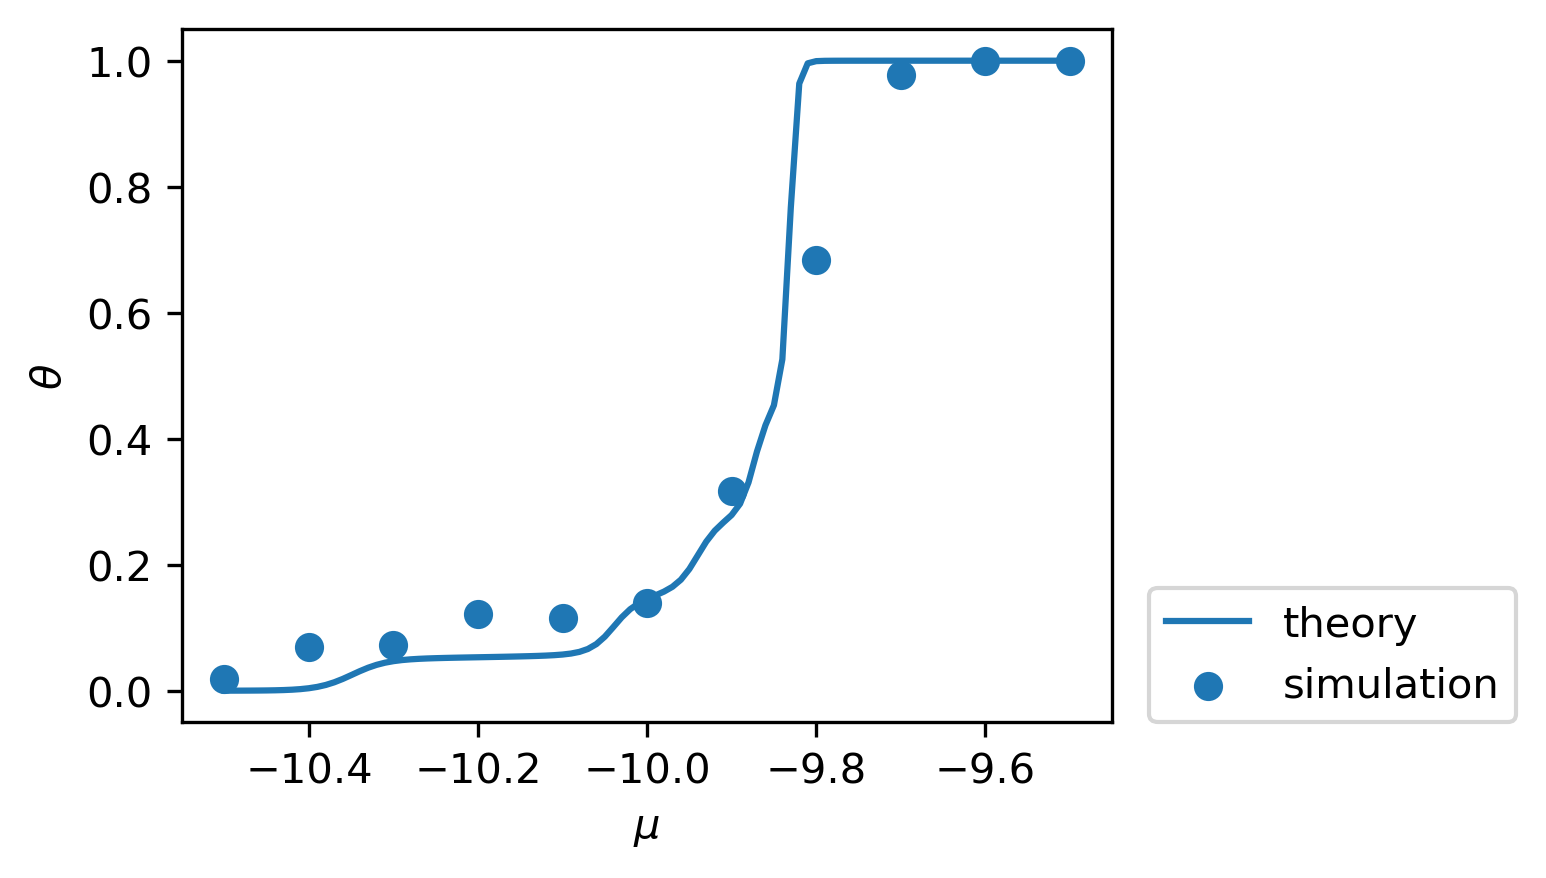

In [12]:
# Calculate binding fractions from simulations
theta_sims = {
    mu: np.sum(sigma.flatten()) / (2 * sigma.shape[0])
    for mu, sigma in all_sigma_sim.items()
}

# Plot the binding isotherm from analytical theory against simulated binding
plt.figure(figsize=(4,3), dpi=300)
plt.plot(all_mu, thetas, label="theory")
plt.scatter(list(theta_sims.keys()), list(theta_sims.values()), label="simulation")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\theta$")
plt.legend(loc=(1.04, 0))
plt.show()